<a href="https://colab.research.google.com/github/DanielGreiner/Masterarbeit/blob/main/Conversion_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reactions

  \begin{array}{lll}
  \text{Methanol steam reforming (MSR):}&\kern 3pc CH_3OH_{(g)}+H_2O_{(g)}\kern 0.5pc{\overset{k_{1, eff}}{\rightleftharpoons}}\kern 0.5pc 3H_{2(g)}+CO_{2(g)}&\kern 3pc\Delta_r H_{m}^{o}= + 49\enspace \frac{kJ}{mol} \\
  \text{Methanol decomposition (MD):}&\kern 3pc CH_3OH_{(g)}\kern 0.5pc {\overset{k_{2, eff}}{\rightleftharpoons}}\kern 0.5pc 2H_{2(g)}+CO_{(g)}&\kern 3pc\Delta_r H_{m}^{o}= + 91\enspace \frac{kJ}{mol} \\
  \end{array}

# Indexing in arrays:

  \begin{array}{llllll}
  \text{Species:} && H_2 & H_2O & CO & CO_2 & CH_3OH \\
  \text{Python Indexing:} && 0 & 1 & 2 & 3 & 4 \\
  \end{array}

# Preliminaries

## LOAD LIBRARIES

In [6]:
# @title import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import stats
import csv

pd.options.mode.chained_assignment = None
pd.set_option('display.width', 200)

In [7]:
#@title thermodynamics library

!pip install thermo
import thermo as thermo

In [17]:
# @title check library versions
print("numpy:" + str(np.__version__))
print("pandas:" + str(pd.__version__))
#print("torch:" + str(to.__version__))

numpy:1.25.2
pandas:1.5.3


## SETUP


In [9]:
# @title reactor constants

'''
Define all reactor specific constants and calculate size of finite differential for numerical integration
'''

L_R = 0.700                 # reactor length [m]
d_R = 0.010                 # reactor diameter [m]
r_R = d_R/2                 # reactor radius [m]

A_R = np.pi*np.power(r_R, 2, dtype=float)               # reactor crossectional area [a.u.]
V_R = A_R*L_R               # reactor volume [m^3]

m_cat = 5/1000              # catalyst mass [kg]
dens_cat_part = 3.28426*np.power(10, 3, dtype=float)    # catalyst particle density [kg m^-3]
dens_cat = 0.96*np.power(10, 3, dtype=float) #old:0.80*np.power(10, 3, dtype=float)      # catalyst bulk density [kg m^-3] use whichever

p_in = 1                    # inlet pressure [bar]
n_Flow_total = 0.08            # inlet molecular flowrate [mol h^-1]
x_MeOH_in = 0.5             # inlet molar fraction methanol
x_H2O_in = 0.5              # inlet molar fraction water
n_Flow_in_MeOH = x_MeOH_in * n_Flow_total         # inlet molecular flowrate methanol [mol h^-1]
n_Flow_in_H2O = x_H2O_in * n_Flow_total           # inlet molecular flowrate water [mol h^-1]

m_cat_0 = 0               # starting mass of catalyst [kg] !! typically 0
steps = 200               # number of steps in numerical calculation
dm_cat_model = (m_cat-m_cat_0)/steps                            # finite differential for numerical integration
m_cat_model_span = np.linspace(m_cat_0, m_cat, steps+1)   # range of mass segments for integration and plotting

R = 8.314                 # universal gas constant [J mol-1 K-1]

M_MeOH = 32.042 #g/mol bzw. kg/kmol
M_H2O = 18.02 #g/mol bzw. kg/kmol
M_H2 = 2.016 #g/mol bzw. kg/kmol
M_CO = 28.010 #g/mol bzw. kg/kmol
M_CO2 = 44.009 #g/mol bzw. kg/kmol

M_array = np.array([M_H2, M_H2O, M_CO, M_CO2, M_MeOH])

# Ergun equation values, partially preliminary
D_cat = 1*np.power(10, -3, dtype=float)                    # catalyst particle diameter [m]
eps = 0.4                 # void fraction in packed bed; assumption = spherical & nearly ideally packed
vel_gas = n_Flow_total/(p_in*np.power(10, 5, dtype=float))*R*(150+273)         # gas velocity [m s^-1]

# deactivation

#deactivation_spacing = 10

# segment to test constants

#print(dm_cat)
#print(m_cat_span)
#print(len(Vspansplit))
#print(stepssplit)
# print(dens_cat)
# print(dens_cat_part)
# print(dens_cat_bulk)

In [10]:
#@title heat duty constants

a_a = 150   #Aziz
a_i = 15    #Aziz
ds = 0.01   #Aziz
lamb = 15   #8 preliminary
k_w = 1/(1/a_i+1/a_a+ds/lamb)
a_w = np.pi*d_R/A_R   # 1/m
# print(k_w)
print(k_w)
print(a_w)

DH_MSR = 49*10^6 # J/kmol
DH_MD = 90*10^6 # J/kmol

13.513513513513514
400.00000000000006


In [11]:
# @title Initial concentrations
'''
setup initial concentrations in an IC array:
'''

n0_H2 = 0                       # [kmol h^-1]
n0_H2O = n_Flow_in_H2O/1000     # [kmol h^-1]
n0_CO = 0                       # [kmol h^-1]
n0_CO2 = 0                      # [kmol h^-1]
n0_MeOH = n_Flow_in_MeOH/1000   # [kmol h^-1]

IC = np.array([n0_H2, n0_H2O, n0_CO, n0_CO2, n0_MeOH, m_cat_0])
IC_zs_0 = IC[:-1]/np.sum(IC[:-1])

In [12]:
#@title thermo

# SI units
# Cpg = [J/kg/K]
# rhog = [kg/m^3]
# mug = [Pa/s]

# H2 = thermo.Chemical('hydrogen', T=450, P=1E5)
# print(H2.Cpg)
# H2O = thermo.Chemical('water', T=450, P=1E5)
# print(H2O.Cpg)
# CO = thermo.Chemical('carbon monoxide', T=450, P=1E5)
# print(CO.Cpg)
# CO2 = thermo.Chemical('carbon dioxide', T=450, P=1E5)
# print(CO2.Cpg)
# MeOH = thermo.Chemical('methanol', T=450, P=1E5)
# print(MeOH.Cpg)

gas_mix_names = ['hydrogen', 'water', 'carbon monoxide', 'carbon dioxide', 'methanol']

gas_prop = thermo.Mixture(gas_mix_names, zs=IC_zs_0, T=450, P=1E5)
print('Spezifische Wärmekapazität der Gasmixtur = ' + str(gas_prop.Cpg) + ' J/kg/K')
print('Dichte der Gasmixtur = ' + str(gas_prop.rhog) + ' kg/m^3')
print('Dynamische Viskosität der Gasmixtur = ' + str(gas_prop.mug) + ' Pa/s')

Spezifische Wärmekapazität der Gasmixtur = 1805.3325184046016 J/kg/K
Dichte der Gasmixtur = 0.6689433460559383 kg/m^3
Dynamische Viskosität der Gasmixtur = 1.5083679245089485e-05 Pa/s


In [13]:
# @title kinetics data

'''
setup kinetics data in arrays, includes S-Kinetics for the MSR and MD reactions respectively
includes activation energies, k0 and exponents for rate of reaction calculation using a modified arrhenius equation
'''

T0 = 150 + 273    # T0 to calculate arrhenius' rate of reaction constant k [K]
n = 1             # exponent in arrhenius equation

#BiCat
#MSR
k0_MSR_S = 8.5*np.power(10, -7, dtype=float)       # k0 for arrhenius[kmol kg^-1 h^-1 Pa^-b]
EA_MSR_S = 54186              # activation energy [J mol-1]
b_MeOH_MSR_S = 0.570           # rate of reaction exponent for methanol
b_H2O_MSR_S = 0.049           # rate of reaction exponent for water

#reverse MSR reaction

k0_MSR_S_rev = 4.2*np.power(10, -6, dtype=float)       # k0 for arrhenius[kmol kg^-1 h^-1 Pa^-b]
EA_MSR_S_rev = 4978                   # activation energy [J mol-1]
b_MeOH_MSR_S_rev = - 0.428            # rate of reaction exponent for methanol
b_H2O_MSR_S_rev = - 0.949             # rate of reaction exponent for water

MSR = np.array(
    [[k0_MSR_S, EA_MSR_S, b_MeOH_MSR_S, b_H2O_MSR_S],
    [k0_MSR_S_rev, EA_MSR_S_rev, b_MeOH_MSR_S_rev, b_H2O_MSR_S_rev]]
)

#MD
k0_MD_S = 1.2*np.power(10, -11, dtype=float)        # [kmol kg^-1 h^-1 Pa^-b]
EA_MD_S = 132540                  # [J mol-1]
b_MeOH_MD_S = 1.114

#reverse MD reaction

k0_MD_S_rev = 5.5*np.power(10, -8, dtype=float)        # [kmol kg^-1 h^-1 Pa^-b]
EA_MD_S_rev = 42137               # [J mol-1]
b_MeOH_MD_S_rev = 0.114

MD = np.array (
    [[k0_MD_S, EA_MD_S, b_MeOH_MD_S],
    [k0_MD_S_rev, EA_MD_S_rev, b_MeOH_MD_S_rev]]
)

# array for stoichiometric coefficients
ny = np.array(
    [[3, -1, 0, 1, -1],
    [2, 0, 1, 0, -1]]
)


# testing block for kinetics arrays


# print(MSR)
# print(MSR[1,1])
#print(ny)

In [14]:
#@title deactivation slope

deactivation_reading = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/deactivation value.csv')
deactivation_value_csv = deactivation_reading.iat[0, 0]

deactivation_list = {}

# Reactor

## PFTR ISOTHERMAL AND STEADY STATE

### ODE by mass catalyst:


$\Large\frac{d\dot{n}_x}{dm_{cat}}=R_x$

$\Large\require{enclose} \frac{dT}{dm_{cat}} = \frac{∑r_i⋅(-𝛥_rH_{m, i}^\enclose{horizontalstrike}{o})}{\dot{m}⋅c_{p, g}}+\frac{k_w\cdot
a_w}{(1-ϵ)⋅ρ_{cat}\dot{m}⋅c_{p, g}}⋅(T_W-T)$

In [ ]:
# @title reaction functions

def ReakFun (P, p_in, T_w, m_flow, g, a_w_loc):
  '''
  calculates the rate of reaction for each component for MSR and MD reactions with respect to the selected catalytic system through indexing
  '''
  # creates new empty concentration array for the components
  dP=np.zeros(len(P))

  # total molar flowrate
  n_ges_temp = np.sum(P[ :-2])

  # calculates molar fraction of all 5 components; original array contains catalyst mass -> ignored in this calculation
  # molar fraction times total pressure = partial pressure; calculated for all 5 components
  for j in range(5):
    P[ j] = P[ j]/n_ges_temp*np.power(10, 5, dtype=float)*1.013 #*p_in

  # assigns components to array index for better readability of calculations
  P_H2 = P[0]
  P_H2O = P[1]
  P_CO = P[2]
  P_CO2 = P[3]
  P_MeOH = P[4]
  m_cat_x = P[5]
  T_neu = P[6]

  gas_prop = g

  # calculates the rate of reaction for each reaction pathway and every catalyst setup
  rMSR = MSR[0, 0] *np.power((T_neu/T0), n, dtype=float)*np.exp((-MSR[0, 1]/R)*(1/T_neu-1/T0), dtype=float)
  rMSR *= np.power(P_MeOH, MSR[0, 2], dtype=float)*np.power(P_H2O, MSR[0, 3], dtype=float)

  # if statement necessary as exponents in reverse reactions are negative -> might divide by zero
  if P_MeOH > 0 and P_H2O > 0:
    revMSR = MSR[1, 0] *np.power((T_neu/T0), n, dtype=float)*np.exp((-MSR[1, 1]/R)*(1/T_neu-1/T0), dtype=float)
    revMSR *= np.power(P_MeOH, MSR[1, 2], dtype=float)*np.power(P_H2O, MSR[1, 3], dtype=float)*-1
  else:
    revMSR = 0

  rMD = MD[0, 0]*np.power((T_neu/T0), n, dtype=float)*np.exp((-MD[0, 1]/R)*(1/T_neu-1/T0), dtype=float)
  rMD *= np.power(P_MeOH, MD[0, 2], dtype=float)

  if P_MeOH > 0:
    revMD = MD[1, 0]*np.power((T_neu/T0), n, dtype=float)*np.exp((-MD[1, 1]/R)*(1/T_neu-1/T0), dtype=float)
    revMD *= np.power(P_MeOH, MD[1, 2], dtype=float)*-1
  else:
      revMD = 0

  # calculates slope of change for each component and returns the result
  dP[0] = (rMSR*ny[0, 0] + rMD*ny[1, 0])+(revMSR*ny[0, 0] + revMD*ny[1, 0])
  dP[1] = (rMSR*ny[0, 1] + rMD*ny[1, 1])+(revMSR*ny[0, 1] + revMD*ny[1, 1])
  dP[2] = (rMSR*ny[0, 2] + rMD*ny[1, 2])+(revMSR*ny[0, 2] + revMD*ny[1, 2])
  dP[3] = (rMSR*ny[0, 3] + rMD*ny[1, 3])+(revMSR*ny[0, 3] + revMD*ny[1, 3])
  dP[4] = (rMSR*ny[0, 4] + rMD*ny[1, 4])+(revMSR*ny[0, 4] + revMD*ny[1, 4])
  dP[5] = 1
  dP[6] = (rMSR*(-DH_MSR) + rMD*(-DH_MD) + revMSR*DH_MSR + revMD*DH_MD)/m_flow/gas_prop.Cpg + k_w*a_w_loc*(T_w-T_neu)/(1-eps)/m_flow/dens_cat/gas_prop.Cpg

  return dP

In [ ]:
# @title reaction functions without reverse reaction

def ReakFunNoReverse (P, T, p_in):
  '''
  calculates the rate of reaction for each component for MSR and MD reactions with respect to the selected catalytic system through indexing
  '''
  # creates new empty concentration array for the components and assigns components to index
  dP=np.zeros(len(P))

  # total molar flowrate
  n_ges_temp = np.sum(P[ :-2])

  # calculates molar fraction of all 5 components; original array contains catalyst mass -> ignored in this calculation
  # molar fraction times total pressure = partial pressure; calculated for all 5 components
  for j in range(5):
    P[ j] = P[ j]/n_ges_temp*p_in*np.power(10, 5, dtype=float)


  P_H2 = P[0]
  P_H2O = P[1]
  P_CO = P[2]
  P_CO2 = P[3]
  P_MeOH = P[4]
  m_cat_x = P[5]

  # calculates the rate of reaction for each reaction pathway and every catalyst setup
  rMSR = MSR[0, 0] *np.power((T/T0), n, dtype=float)*np.exp((-MSR[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMSR *= np.power(P_MeOH, MSR[0, 2], dtype=float)*np.power(P_H2O, MSR[0, 3], dtype=float)


  rMD = MD[0, 0]*np.power((T/T0), n, dtype=float)*np.exp((-MD[0, 1]/R)*(1/T-1/T0), dtype=float)
  rMD *= np.power(P_MeOH, MD[0, 2], dtype=float)


  # calculates slope of change for each component and returns the result
  dP[0] = (rMSR*ny[0, 0] + rMD*ny[1, 0])
  dP[1] = (rMSR*ny[0, 1] + rMD*ny[1, 1])
  dP[2] = (rMSR*ny[0, 2] + rMD*ny[1, 2])
  dP[3] = (rMSR*ny[0, 3] + rMD*ny[1, 3])
  dP[4] = (rMSR*ny[0, 4] + rMD*ny[1, 4])
  dP[5] = 1
  dP[6] = T

  return dP

## Euler and deactivation

In [ ]:
# @title euler's method

def EulFun (y, T, p_in, m_cat_span, dm_cat, iterations, a_w_loc):
  '''
    uses eulers method to calculate the change in concentration given the slope
  '''

  massflow = y[:-1]*M_array
  massflow_total = np.sum(massflow)/3600

  T_W = T
  y = np.append(y, T)

  # creates empty concentration array and inputs the initial conditions as the first data point
  ytemp = np.zeros([len(m_cat_span), len(y)])
  ytemp[0,:] = y

  # takes a copy of the last entry in the ytemp results array for the next calculation step
  for i in range(iterations):
    y = np.transpose(ytemp[i, :])
    temp = y.copy()

    # print("temp = ")
    # print(temp)

    IC_zs = temp[:-2]/np.sum(temp[:-2])

    # print(IC_zs)
    # print(temp[-1])
    if i%10 == 0:
        gasmixture = thermo.Mixture(gas_mix_names, zs=IC_zs, T=temp[-1], P=p_in*10**5)

    # print(gasmixture.rhog, gasmixture.Cpg)
    # gets differential from reaction function

    dy = ReakFun(temp, p_in, T_W, massflow_total, gasmixture, a_w_loc)

    # print("dy = ")
    # print(dy)
    # next entry in results array according to euler's method dependant on integration variable dm_cat
    ytemp[i+1, :] = y + dy*dm_cat

    # removes negative entries, might exist due to slope and step size
    for j in range(5):
      if ytemp[i+1, j] <= 0:
        ytemp[i+1, j] = 0

  return ytemp

In [ ]:
# @title euler's method no reverse

def EulFunNoReverse (y, T, p_in, m_cat_span, dm_cat, iterations):
  '''
  uses eulers method to calculate the change in concentration given the slope
  '''

  # creates empty concentration array and inputs the initial conditions as the first data point
  y = np.append(y, T)

  ytemp = np.zeros([len(m_cat_span), len(y)])
  ytemp[0,:] = y


  for i in range(iterations):
    y = np.transpose(ytemp[i, :])
    temp = y.copy()

    dy = ReakFunNoReverse(y, T, p_in)

    ytemp[i+1, :] = temp + dy*dm_cat

    for j in range(5):
      if ytemp[i+1, j] <= 0:
        ytemp[i+1, j] = 0

  # transposes last set of concentrations into a vector to input as the initial conditions for the reaction function
  # finite change calculated and input as IC for next iteration to fill the array
  return ytemp

In [ ]:
# @title deactivation function

def DeacFun(X_t_T_p):
  '''
  uses a deactivation function to calculate the change in catalytic efficiency given a time array
  '''
  # the calculation is preliminary and will be corrected later with respect to the present pressure
  # just to test if deactivation function works and can be implemented

  Xt = X_t_T_p.copy()

  deactivation_slope_old = 0

  for i in range(len(Xt)):
    if i == 0:
        deactivation_slope = deactivation_value_csv * Xt[i, 2] * (Xt[i, 3]**2.228) * (Xt[i, 1])
    else:
        deactivation_slope = deactivation_value_csv * Xt[i, 2] * (Xt[i, 3]**2.228) * (Xt[i, 1] - Xt[i -1, 1])
    deactivation_slope_total = deactivation_slope + deactivation_slope_old
    Xt[i, 0] = Xt[i, 0] * (1 + deactivation_slope_total)
    deactivation_slope_old = deactivation_slope_total

  for i in range(len(Xt)):
    if Xt[i, 0] < 0:
        Xt[i, 0] = 0

  return Xt

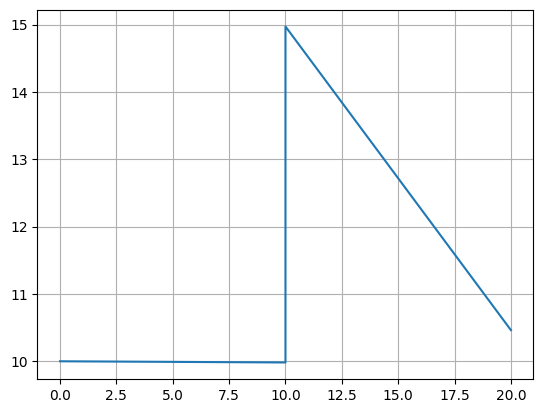

In [ ]:
#@title deactivation debugging and testing

# deactivation_value = -0.00005

X = np.array([[10.0, 0, 427, 1], [10.0, 10, 427, 1], [15.0, 10, 427, 1], [10.5, 20, 427, 1]])
xz = DeacFun(X)


plt.plot(xz[:, 1], xz[:, 0])
plt.grid()

## MAIN

In [ ]:
# @title Main calculation, pressure result

def MainCalcPressure (y, T, p_in, m_cat_span, dm_cat, iterations, rev, a_w_loc):


  if rev == 1:
    temp_solution = EulFunNoReverse(y, T, p_in, m_cat_span, dm_cat, iterations)
  else:
    temp_solution = EulFun(y, T, p_in, m_cat_span, dm_cat, iterations, a_w_loc)

  # turns molar flowrates into pressures, for every entry except mass catalyst
  for l in range(len(temp_solution)):
    n_ges = np.sum(temp_solution[l, :-2])

    for j in range(5):
      temp_solution[l, j] = temp_solution[l, j]/n_ges*p_in

  return temp_solution

In [ ]:
# @title Main calculation, molar flowrate result

def MainCalcMolFlow (y, T, p_in, m_cat_span, dm_cat, iterations, rev, a_w_loc):

  if rev == 1:
    temp_solution = EulFunNoReverse(y, T, p_in, m_cat_span, dm_cat, iterations)
  else:
    temp_solution = EulFun(y, T, p_in, m_cat_span, dm_cat, iterations, a_w_loc)

  return temp_solution

In [ ]:
#@title main function

'''
contains main function to call all other relevant functions and set temperature and reaction index
'''
# set reaction temperature and calculate respective volumetric flowrate

T = 273 + 150                                                                 # reactor temperature [K]
VFlow = n_Flow_total*R*T/(p_in * np.power(10, 5, dtype = float))              # volumetric flowrate [m^3 h^-1]

# calculates a concentration array using euler's method, with the length Vspan for plotting

pEul = MainCalcPressure(IC, T, p_in, m_cat_model_span, dm_cat_model, steps, 0, a_w)

pEulNoReverse = MainCalcPressure(IC, T, p_in, m_cat_model_span, dm_cat_model, steps, 1, a_w)

pEulfrac = pEul.copy()

### testing ###

# pEul2 = MainCalcMolFlow(IC, T, p_in, m_cat_model_span, dm_cat_model, steps, 0)

# pEul2frac = pEul2.copy()
# n_ges_pEul2 = np.zeros(len(pEul2frac))
# n_ges_pEul2[:] = np.sum(pEul2frac[:, :-1], 1)
# for i in range(len(pEul2frac)):
#   pEul2frac[i, :-1] = pEul2frac[i, :-1]/n_ges_pEul2[i]

# Main Plots

## MAIN PLOTS

Text(0, 0.5, 'Temperature [K]')

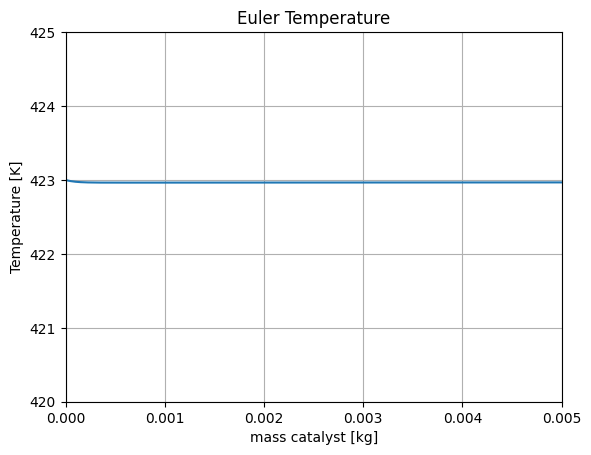

In [ ]:
#@title temp plot
plt.figure(1)
plt.plot(pEulfrac[:,5], pEulfrac[:,-1])
plt.title("Euler Temperature")
plt.axis((0, 0.005, 420, 425))
plt.grid()
plt.xlabel("mass catalyst [kg]")
plt.ylabel ("Temperature [K]")

Text(0, 0.5, 'molar fraction')

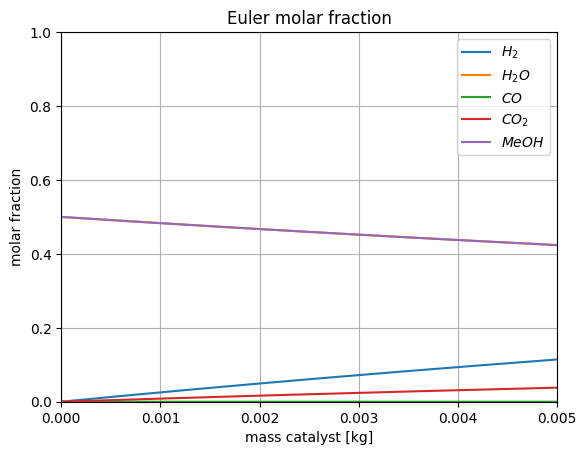

In [ ]:
# @title full plot

'''
plots both reactors in the cascade using euler's method and the runge kutta method
'''
# # at p = 1 bar, the pressure and molar fraction are identical, might uncomment when looking at different pressures
# plt.figure(1)
# plt.plot(pEul[:,5], pEul[:,0], label='$H_2$')
# plt.plot(pEul[:,5], pEul[:,1], label='$H_2O$')
# plt.plot(pEul[:,5], pEul[:,2], label='$CO$')
# plt.plot(pEul[:,5], pEul[:,3], label='$CO_2$')
# plt.plot(pEul[:,5], pEul[:,4], label='$MeOH$')
# plt.title("Euler pressure")
# plt.axis((0, 8, 0, 1))
# plt.legend(loc='best')
# plt.grid()
# plt.xlabel("mass catalyst [kg]")
# plt.ylabel ("pressure [bar]")

plt.figure(2)
plt.plot(pEulfrac[:,5], pEulfrac[:,0], label='$H_2$')
plt.plot(pEulfrac[:,5], pEulfrac[:,1], label='$H_2O$')
plt.plot(pEulfrac[:,5], pEulfrac[:,2], label='$CO$')
plt.plot(pEulfrac[:,5], pEulfrac[:,3], label='$CO_2$')
plt.plot(pEulfrac[:,5], pEulfrac[:,4], label='$MeOH$')
plt.title("Euler molar fraction")
plt.axis((0, 0.005, 0, 1))
plt.legend(loc='best')
plt.grid()
plt.xlabel("mass catalyst [kg]")
plt.ylabel ("molar fraction")

Text(0, 0.5, 'methanol conversion [%]')

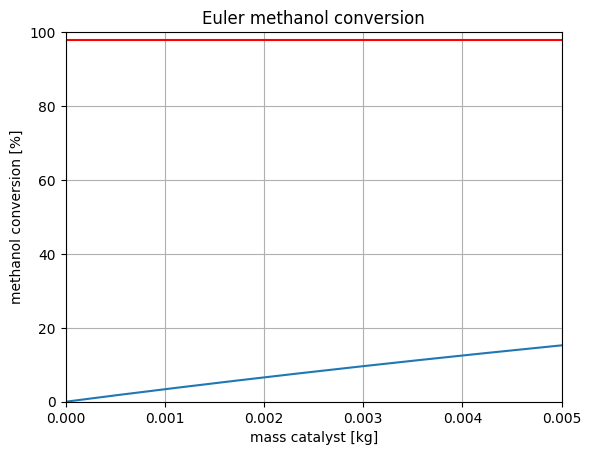

In [ ]:
# @title methanol conversion
'''
used to calculate the conversion of methanol
'''
# copy to not change original array
EulFracX = pEulfrac.copy()
EulFracX = np.delete(EulFracX, [0, 1, 2, 3], 1)

# X = 1-n/n0
EulFracX[:, 0] = (1-EulFracX[:, 0]/EulFracX[0, 0])*100

# plots results and adds horizontal line at X = 98%
plt.figure(1)
plt.plot(EulFracX[:, 1], EulFracX[:, 0], label='$MeOH$')
plt.axhline(y=98, color='r')
plt.title("Euler methanol conversion")
plt.axis((0, 0.005, 0, 100))
#plt.legend(loc='best')
plt.grid()
plt.xlabel("mass catalyst [kg]")
plt.ylabel ("methanol conversion [%]")

# pEulfracX[:,5] = pEulfracX[:,5] * dens_cat * A_R

# plt.figure(2)
# plt.plot(pEulfracX[:,5], pEulfracX[:,4], label='$MeOH$')
# plt.title("Euler methanol conversion")
# plt.axis((16.6, 16.7, 97, 100))
# plt.legend(loc='best')
# plt.grid()
# plt.xlabel("mass catalyst [kg]")
# plt.ylabel ("methanol conversion [%]")

Text(0, 0.5, 'pressure [bar]')

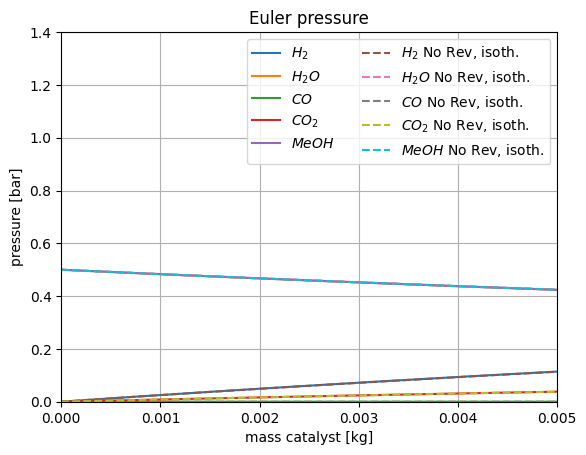

In [ ]:
# @title no reverse reaction comparison
'''
plots results of euler with and without reverse reaction
'''
plt.figure(1)
plt.plot(pEul[:,5], pEul[:,0], label='$H_2$')
plt.plot(pEul[:,5], pEul[:,1], label='$H_2O$')
plt.plot(pEul[:,5], pEul[:,2], label='$CO$')
plt.plot(pEul[:,5], pEul[:,3], label='$CO_2$')
plt.plot(pEul[:,5], pEul[:,4], label='$MeOH$')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,0], label='$H_2$ No Rev, isoth.', linestyle='--')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,1], label='$H_2O$ No Rev, isoth.', linestyle='--')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,2], label='$CO$ No Rev, isoth.', linestyle='--')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,3], label='$CO_2$ No Rev, isoth.', linestyle='--')
plt.plot(pEulNoReverse[:,5], pEulNoReverse[:,4], label='$MeOH$ No Rev, isoth.', linestyle='--')
plt.title("Euler pressure")
plt.axis((0, 0.005, 0, 1.40))
plt.legend(loc='best', ncol=2)
plt.grid()
plt.xlabel("mass catalyst [kg]")
plt.ylabel ("pressure [bar]")

Text(0, 0.5, 'difference [%]')

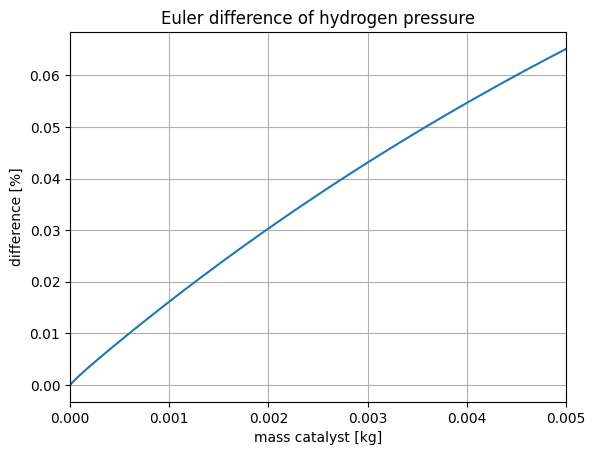

In [ ]:
# @title hydrogen difference no reverse reaction
'''
calculates the difference of resulting pressure along the reactor axis between both reactions and omitting the reverse reaction in %
'''
# difference in %
difference = (pEul[:,0]-pEulNoReverse[:,0])*100

# plots difference
plt.figure(1)
plt.plot(pEul[:,5], difference)
plt.title("Euler difference of hydrogen pressure")
plt.xlim(0, 0.005)
plt.grid()
plt.xlabel("mass catalyst [kg]")
plt.ylabel ("difference [%]")

# Conversion prediction

## Initials

In [ ]:
m_cat_min = 1                           # g
m_cat_max = 15                          # g

M_In_Mid = 0.5 * (M_MeOH + M_H2O)       # g/mol
m_in_min = 0.5                          # g/h
n_in_min = m_in_min/M_In_Mid            # mol/h
m_in_max = 20                           # g/h
n_in_max = m_in_max/M_In_Mid            # mol/h

T_lookup = 150 + 273                    # K
p_in_lookup = 1                         # bar
m_cat_steps = int(m_cat_max/m_cat_min)
n_steps = int(m_in_max/m_in_min)

n0_CO = 0                       # [kmol h^-1]
n0_CO2 = 0                      # [kmol h^-1]
n0_H2 = 0                       # [kmol h^-1]

## Create lookup table

old calc~ 31 hours

new calc with 15*20 = 300 and 2min 40s = 160s

--> ~2 $\frac{1}{s}$ frequency

maybe introduce fronting of accuracy in heat duty calculation

In [ ]:
#@title create table

# lookup_array = np.zeros([n_steps*m_cat_steps, 5])
# lookup_array[:, 3] = T_lookup
# lookup_array[:, 4] = p_in_lookup

# cat_range = np.linspace(m_cat_min, m_cat_max, m_cat_steps)
# n_in_range = np.linspace(n_in_min, n_in_max, n_steps)

# for i in range (m_cat_steps):
#     m_cat_it = cat_range[i]/1000
#     dm_cat_model_lookup = m_cat_it/steps
#     m_cat_model_span_lookup = np.linspace(0, m_cat_it, steps+1)

#     for j in range (n_steps):
#         n_in_it = n_in_range[j]
#         n0_H2O = n_in_it/1000/2    # [kmol h^-1]
#         n0_MeOH = n_in_it/1000/2   # [kmol h^-1]

#         IC_lookup = np.array([n0_H2, n0_H2O, n0_CO, n0_CO2, n0_MeOH, m_cat_0])

#         results = MainCalcMolFlow(IC_lookup, T_lookup, p_in_lookup, m_cat_model_span_lookup, dm_cat_model_lookup, steps, 0, a_w)
#         X_it = (1 - results[-1, 4]/results[0, 4]) * 100
#         lookup_array[n_steps * i + j, 0] = m_cat_it * 1000
#         lookup_array[n_steps * i + j, 1] = n_in_it
#         lookup_array[n_steps * i + j, 2] = X_it

# lookup_df = pd.DataFrame(lookup_array, columns=['Mass catalyst [g]', 'Total inlet molar flowrate [mol/h]', 'Conversion [%]', 'Temperature [K]', 'Pressure [bar]'])

In [ ]:
#@title write table result

#lookup_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/Conversion lookup table.csv', index=False)

## Use lookup table

In [ ]:
#@title get table again

filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/Conversion lookup table.csv'
lookup_df = pd.read_csv(filepath)

In [ ]:
lookup_df['Total inlet mass flowrate [g/h]'] = lookup_df['Total inlet molar flowrate [mol/h]'] * M_In_Mid
lookup_df

,Mass catalyst [g],Total inlet molar flowrate [mol/h],Conversion [%],Temperature [K],Pressure [bar],Total inlet mass flowrate [g/h]
0,1.0,0.019975,6.678141,423.0,1.0,0.5
1,1.0,0.039950,3.408015,423.0,1.0,1.0
2,1.0,0.059926,2.287940,423.0,1.0,1.5
3,1.0,0.079901,1.722042,423.0,1.0,2.0
4,1.0,0.099876,1.380598,423.0,1.0,2.5
...,...,...,...,...,...,...
595,15.0,0.719108,2.849913,423.0,1.0,18.0
596,15.0,0.739084,2.774198,423.0,1.0,18.5
597,15.0,0.759059,2.702403,423.0,1.0,19.0
598,15.0,0.779034,2.634230,423.0,1.0,19.5


In [ ]:
#@title lookup function

def lookup_loop (X_in, m_cat_in, n_in):

    p_loop = 1
    T_loop = 150 + 273
    calc_cutoff = 0.01

    if m_cat_in == 0:
        #lookup_temp =
        #IC_loop = np.array([0, n_in/2, 0, 0, n_in/2, TBD])
        m_cat_out = 1

        return m_cat_out, n_in

    elif n_in == 0:
        lookup_temp = lookup_df.loc[lookup_df['Mass catalyst [g]'] == m_cat_in]

        if lookup_temp['Conversion [%]'].iat[0] < X_in:
            p = print('Selected conversion too high for amount of catalyst')
            return p

        temploc = (lookup_temp.loc[lookup_temp['Conversion [%]'] > X_in]['Conversion [%]'] - X_in).abs().idxmin()
        n_flow_1 = lookup_temp.at[temploc, 'Total inlet molar flowrate [mol/h]']
        n_flow_2 = lookup_temp.at[temploc + 1, 'Total inlet molar flowrate [mol/h]']
        n_flow_start = (n_flow_1 + n_flow_2)/2

        IC_loop = np.array([0, n_flow_start/2, 0, 0, n_flow_start/2, 0])
        m_cat_loop_span = np.linspace(0, m_cat_in, steps + 1)
        dm_cat_loop = m_cat_in/steps
        res_array_start = MainCalcMolFlow(IC_loop, T_loop, p_loop, m_cat_loop_span, dm_cat_loop, steps, 0, a_w)
        X_calc = (1 - res_array_start[-1, 4]/(n_flow_start/2)) * 100

        if X_calc > X_in:
                n_1 = n_flow_start
                n_2 = n_flow_2
                n_3 = (n_flow_start + n_flow_2)/2
        else:
                n_1 = n_flow_1
                n_2 = n_flow_start
                n_3 = (n_flow_start + n_flow_1)/2

        while abs(X_calc - X_in) > calc_cutoff:
            IC_loop = np.array([0, n_3/2, 0, 0, n_3/2, 0])
            res_array_start = MainCalcMolFlow(IC_loop, T_loop, p_loop, m_cat_loop_span, dm_cat_loop, steps, 0, a_w)
            X_calc = (1 - res_array_start[-1, 4]/(n_3/2)) * 100
            if X_calc > X_in:
                n_1 = n_3
                n_2 = n_2
                n_3 = (n_3 + n_2)/2
            else:
                n_1 = n_1
                n_2 = n_3
                n_3 = (n_3 + n_1)/2

        p = print('Calculated conversion: ' + str(X_calc.round(1)) + ' % \n'
                    'with a total inlet flowrate of ' + str((n_3*M_In_Mid).round(5)) + ' g/h \n'
                    'and a catalyst mass of ' + str(m_cat_in) + ' g')
        return p

In [ ]:
#@title results

X_lookup = 17
m_cat_lookup = 12
n_flow_lookup = 0
looping = lookup_loop(X_lookup, m_cat_lookup, n_flow_lookup)
# print('Calculated conversion: ' + str(looping[0].round(1)) + ' % \n'
#       'with a total inlet flowrate of ' + str(looping[1].round(5)) + ' g/h \n'
#       'and a catalyst mass of ' + str(looping[2]) + ' g')

Calculated conversion: 17.0 % 
with a total inlet flowrate of 2.20898 g/h 
and a catalyst mass of 12 g


### testing

In [ ]:
lookup_df.loc[lookup_df['Mass catalyst [g]'] == 3]

,Mass catalyst [g],Total inlet molar flowrate [mol/h],Conversion [%],Temperature [K],Pressure [bar],Total inlet mass flowrate [g/h]
80,3.0,0.019975,18.569350,423.0,1.0,0.5
81,3.0,0.039950,9.820914,423.0,1.0,1.0
82,3.0,0.059926,6.678141,423.0,1.0,1.5
83,3.0,0.079901,5.059605,423.0,1.0,2.0
84,3.0,0.099876,4.072701,423.0,1.0,2.5
85,3.0,0.119851,3.408015,423.0,1.0,3.0
86,3.0,0.139827,2.929878,423.0,1.0,3.5
87,3.0,0.159802,2.569413,423.0,1.0,4.0
88,3.0,0.179777,2.287940,423.0,1.0,4.5
89,3.0,0.199752,2.062055,423.0,1.0,5.0


In [ ]:
cond = 10
cond2 = 0.48
fhg = lookup_df.loc[(lookup_df['Mass catalyst [g]'] - cond).abs().min()]
fhg

Mass catalyst [g]                       1.000000
Total inlet molar flowrate [mol/h]      0.019975
Conversion [%]                          6.678141
Temperature [K]                       423.000000
Pressure [bar]                          1.000000
Total inlet mass flowrate [g/h]         0.500000
Name: 0, dtype: float64

## Plots

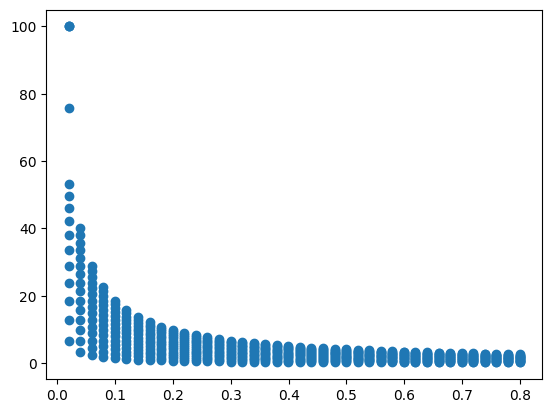

In [ ]:
plt.scatter(lookup_df['Total inlet molar flowrate [mol/h]'], lookup_df['Conversion [%]'])

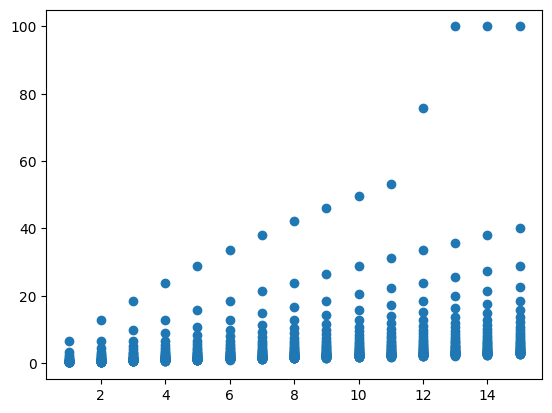

In [ ]:
plt.scatter(lookup_df['Mass catalyst [g]'], lookup_df['Conversion [%]'])